In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
def read_and_decode_single_example(filename):
    # first construct a queue containing a list of filenames.
    # this lets a user split up there dataset in multiple files to keep
    # size down
    filename_queue = tf.train.string_input_producer([filename],
                                                    num_epochs=None)
    # Unlike the TFRecordWriter, the TFRecordReader is symbolic
    reader = tf.TFRecordReader()
    # One can read a single serialized example from a filename
    # serialized_example is a Tensor of type string.
    _, serialized_example = reader.read(filename_queue)
    # The serialized example is converted back to actual values.
    # One needs to describe the format of the objects to be returned
    features = tf.parse_single_example(
        serialized_example,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            # 'label': tf.VarLenFeature(tf.int64),
            'label': tf.FixedLenFeature([], tf.int64),
            'image': tf.FixedLenFeature([256 * 256 * 3], tf.int64)
        })
    # now return the converted data
    label = features['label']
    image = features['image']
    return label, image

In [4]:
label, image = read_and_decode_single_example('../data/cells_train.tfrecords')

In [5]:
sess = tf.Session()
init = tf.global_variables_initializer()
tf.train.start_queue_runners(sess=sess)

label_val_1, image_val_1 = sess.run([label, image])
# second example from file
label_val_2, image_val_2 = sess.run([label, image])

In [6]:
label_val_1, image_val_1

(2, array([41, 41, 43, ..., 35, 35, 37]))

In [7]:
# get single examples
label, image = read_and_decode_single_example("../data/cells_train.tfrecords")
# Normalize the images to [-0.5, 0.5]
image = (tf.cast(image, tf.float32) / 255. ) - 0.5
# The following groups the examples into batches randomly
images_batch, labels_batch = tf.train.shuffle_batch(
    [image, label], batch_size=40,
    capacity=400,
    min_after_dequeue=200)

# The model: y_pred = Wx + b
W = tf.get_variable("W", [256 * 256 * 3, 3])
b = tf.get_variable("b", [3])
y_pred = tf.matmul(images_batch, W) + b
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(y_pred, labels_batch)

# We can use this for monitoring with TensorBoard:
loss_mean = tf.reduce_mean(loss)

train_op = tf.train.AdamOptimizer().minimize(loss)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
tf.train.start_queue_runners(sess=sess)

n_iterations = 100
losses = []
#with tf.name_scope('train'):
for ii in range(n_iterations):
    # pass it in through the feed_dict
    _, loss_val = sess.run([train_op, loss_mean])
    losses.append(loss_val)
#merged = tf.summary.merge_all()
#train_writer = tf.summary.FileWriter(op.join('.', 'train'), sess.graph)

In [8]:
y_pred = tf.matmul(images_batch, W) 

In [9]:
np.mean(sess.run(tf.equal(tf.argmax(y_pred, 1), labels_batch)))

0.52500000000000002

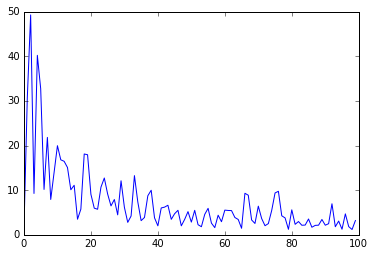

In [10]:
plt.plot(losses)

In [11]:
test_iter = tf.python_io.tf_record_iterator('../data/cells_test.tfrecords')

In [12]:
correct_prediction = []
for ii, this_test in enumerate(test_iter):
    ex = tf.parse_single_example(this_test, 
                                 features={'label': tf.FixedLenFeature([], tf.int64),
                                           'image': tf.FixedLenFeature([1, 256 * 256 * 3], tf.int64)})
    x, y = ex['image'], ex['label']
    x = (tf.cast(x, tf.float32) / 255. ) - 0.5
    y_pred = tf.matmul(x, W) + b
    correct_prediction.append(sess.run(tf.equal(tf.argmax(y_pred, 1), label)))


In [13]:
np.mean(correct_prediction)

0.378698224852071